# Used Car Dataset Price Prediction using Linear Regression

In [2]:
# IMPORT LIBRARIES
try:
    # PYSPARK
    from pyspark.sql import SparkSession
    from pyspark import SparkContext
    from pyspark.sql import SQLContext
    from pyspark.sql import DataFrame
    import pyspark.sql.types as tp
    import pyspark.sql.functions as F
    from pyspark.mllib.stat import Statistics
    
    #Py Spark ML Libraries
    from pyspark.ml.classification import LogisticRegression
    from pyspark.ml.regression import LinearRegression
    from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
    from pyspark.ml import Pipeline
    from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
    
    # OTHER LIBRARIES
    import pandas as pd
    import numpy as np
    import glob
    from functools import reduce
    import seaborn as sns
    import matplotlib.pyplot as plt
    from urllib.request import urlopen
    import datetime
    from pathlib import Path
    import six
    
    print('[SUCCESS]')

    #CATCH ERROR IMPORTING A LIBRARY
except ImportError as ie:
    raise ImportError(f'[Error importing]: {ie}')

[SUCCESS]


## Initializing Spark session and cluster for work enviornment

In [3]:
'''
INITIALIZING SPARK SESSION
- NAME IS SET FOR SPARK SESSION WHEN RUNNING ON LOCAL HOST
'''
spark = SparkSession.builder.master('local').config("spark.executor.memory", "1g").config("spark.driver.memory", "2g").appName('UsedCar_Project').getOrCreate()
print('[SUCCESSFULLY RUNNING SPARK SESSION]')


[SUCCESSFULLY RUNNING SPARK SESSION]


# Load data

In [4]:
def load_data():
    '''
    car_prices.csv is uploaded to a google bucket for public use. Since file is too large to push to GitHub for others to use from repo
    this function will load the data from the google bucket.
    
    You can run this function each time and it will not download a new dataset each time since the first time you run it, it will download locally to your directory.
    --- unless you delete it each time
    
    Function will check to make sure file is in the directory
    - if it is, load it to a spark dataframe
    - if it is not, download it, then load it to a spark dataframe
    
    SCHEMA:
    - Created a schema to make sure the data types for the file being read is kept
    
    
    Drop Randome Values in state columns
    
    
    WARNING: TO USE THIS FUNCTION, YOU HAVE TO BE RUNNING JUPYTER NOTEBOOK ON A LINUX SERVER (USE DOCKER)
    
    NOTES:
    option("header",True).option("inferSchema", True)
    '''
    
    # CHECKS TO SEE IF FILE EXIST
    path = Path('car_prices.csv') 
    
    # IF FILE DOES NOT EXIST
    if not path.is_file():
        !wget https://storage.googleapis.com/iamangelsh-public-datasets/car_prices.csv 
    
    
    
    # CREATE SCHEMA TO KEEP DATA TYPES
    schema = tp.StructType([tp.StructField('year', tp.IntegerType(), True),
                           tp.StructField('make', tp.StringType(), True),
                           tp.StructField('model', tp.StringType(), True),
                           tp.StructField('trim', tp.StringType(), True),
                           tp.StructField('body', tp.StringType(), True),
                           tp.StructField('transmission', tp.StringType(), True),
                           tp.StructField('vin', tp.StringType(), True),
                           tp.StructField('state', tp.StringType(), True),
                           tp.StructField('condition', tp.DoubleType(), True),
                           tp.StructField('odometer', tp.DoubleType(), True),
                           tp.StructField('color', tp.StringType(), True),
                           tp.StructField('interior', tp.StringType(), True),
                           tp.StructField('seller', tp.StringType(), True),
                           tp.StructField('mmr', tp.IntegerType(), True),
                           tp.StructField('sellingprice', tp.IntegerType(), True),
                           tp.StructField('saledate', tp.StringType(), True)])
    
    
    # LOAD IN DATA WITH SCHEMA
    df = spark.read.csv("car_prices.csv", header = True, sep=",", schema=schema)
    
    old_df = df
    
    
    # FILTER OUT VIN NUMBERS FROM STATE COLUMN
    df = df.where(F.length(F.col("state")) <= 2)
    
    # DROP ROWS THAT CONTAIN NULL VALUES
    df = df.na.drop('any')
    
    # CREATE THRESHOLD FOR CONDITION COLUMN
    df = df.withColumn(
        'condition', 
        F.when(df.condition > 3.75, 'Great'
        ).when((df.condition >= 2) & (df.condition <= 3.75), 'Average'
        ).when(df.condition < 2, 'Bad'))
    
    # DROP COLUMNS THAT WON'T BE USED
    cols = ('trim', 'vin', 'interior', 'seller')
    df = df.drop(*cols)
    
    
    # USE MM DD YYYY FOR SALEDATE COLUMN
    df = df.withColumn(
        'saledate', F.substring('saledate', 5,11)
        ).withColumn(
        'saledate_year', F.substring('saledate', 7,5)
        ).withColumn(
        'saledate_month', F.substring('saledate', 1,3))
    
    df = df.withColumn(
        'saledate_year', F.col('saledate_year').cast(tp.IntegerType())
        )
    
    # RETURN NEW DATAFRAME
    return df, old_df


# LOAD THE DATA
df, old_df = load_data()

# SHOW DATA
df.show(5)

# SHOW NUMBER OF COLUMNS AND ROWS
print('Data for uncleaned DataFrame')
print(f'Number of columns: {len(old_df.columns)} \nNumber of Rows: {old_df.count()}')
print()
print('Data for cleaned DataFrame')
print(f'Number of columns: {len(df.columns)} \nNumber of Rows: {df.count()}')


# SHOW SCHEMA - DATATYPES
df.printSchema()

+----+-----+-------------------+-----+------------+-----+---------+--------+-----+-----+------------+-----------+-------------+--------------+
|year| make|              model| body|transmission|state|condition|odometer|color|  mmr|sellingprice|   saledate|saledate_year|saledate_month|
+----+-----+-------------------+-----+------------+-----+---------+--------+-----+-----+------------+-----------+-------------+--------------+
|2015|  Kia|            Sorento|  SUV|   automatic|   ca|    Great| 16639.0|white|20500|       21500|Dec 16 2014|         2014|           Dec|
|2015|  Kia|            Sorento|  SUV|   automatic|   ca|    Great|  9393.0|white|20800|       21500|Dec 16 2014|         2014|           Dec|
|2014|  BMW|           3 Series|Sedan|   automatic|   ca|    Great|  1331.0| gray|31900|       30000|Jan 15 2015|         2015|           Jan|
|2015|Volvo|                S60|Sedan|   automatic|   ca|    Great| 14282.0|white|27500|       27750|Jan 29 2015|         2015|           Jan|

## Check for null values in our dataframe

In [8]:
def null_values(df):
    '''
    TAKES IN A DATAFRAME AND RETURNS THE COUNT OF NULL VALUES IN EACH COLUMN
    '''
    return df.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns])

NULL_VAL_COUNTS_OLD_DF = null_values(old_df)
NULL_VAL_COUNTS_OLD_DF.show()

print('After dropping Null values')
print()
NULL_VAL_COUNTS = null_values(df)
NULL_VAL_COUNTS.show()


+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|year| make|model| trim| body|transmission|vin|state|condition|odometer|color|interior|seller|mmr|sellingprice|saledate|
+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|   0|10301|10399|10651|13195|       65353|  4|    0|    11820|      94|  749|     749|     0| 26|           0|       0|
+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+

After dropping Null values

+----+----+-----+----+------------+-----+---------+--------+-----+---+------------+--------+-------------+--------------+
|year|make|model|body|transmission|state|condition|odometer|color|mmr|sellingprice|saledate|saledate_year|saledate_month|
+----+----+-----+----+------------+-----+---------+--------+-----+---+------------+--------+-------------+--------------+


**Function to graph our visual selections for better comprehension**

In [5]:
def plot_basic_visuals(df, col_name: str):
    '''
    Parameters:
    - PySpark Dataframe with only 2 columns
    - Column name that we want to plot (as a string)
    
    Uses:
    - Function will select desired column, group by column and count each type
    - Function will convert PySpark Dataframe into a Pandas Dataframe
    - Will then plot x and y 
    '''
    df = df.select([col_name]).groupBy(col_name).count()
    pandas_df = df.toPandas()
    pandas_df.plot(kind='bar', x=pandas_df.columns[0], y=pandas_df.columns[1], colormap='winter_r', figsize=(20,6))
    
    


**Visuals on Columns by count and type**

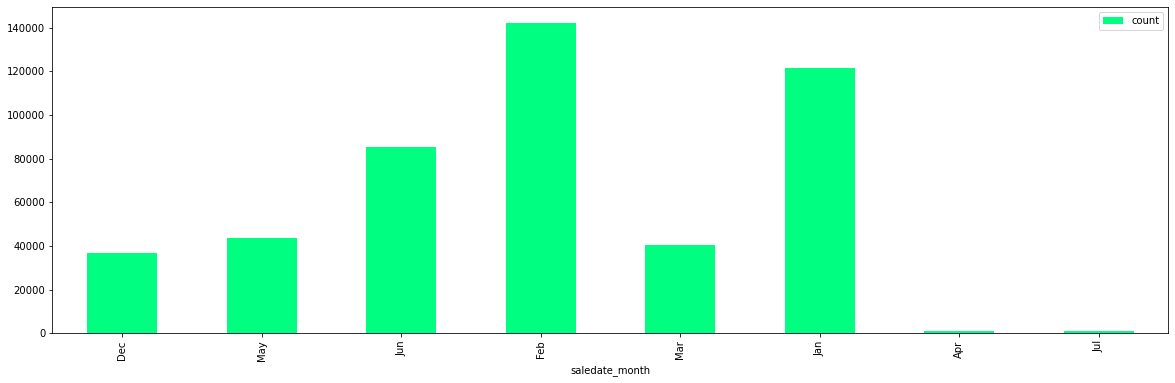

In [6]:
plot_basic_visuals(df, 'saledate_month')

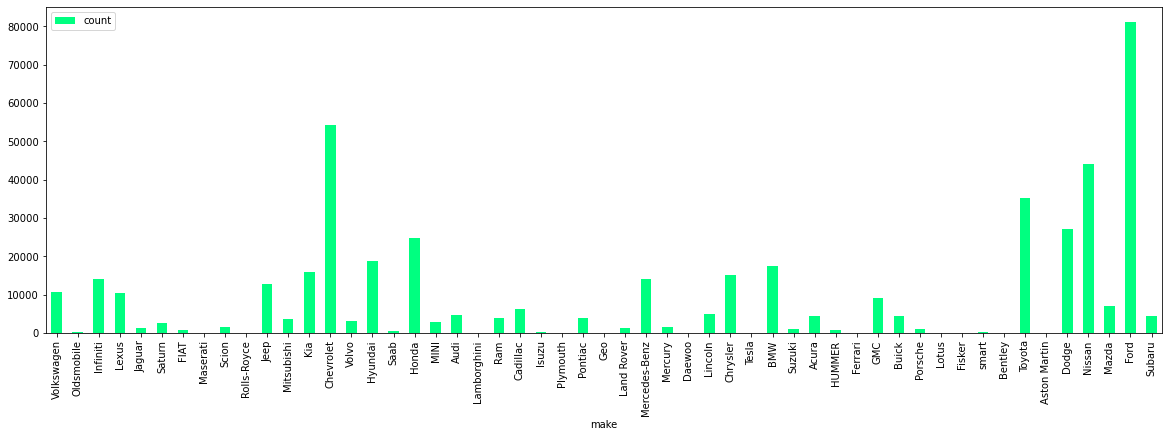

In [95]:
plot_basic_visuals(df, 'make')

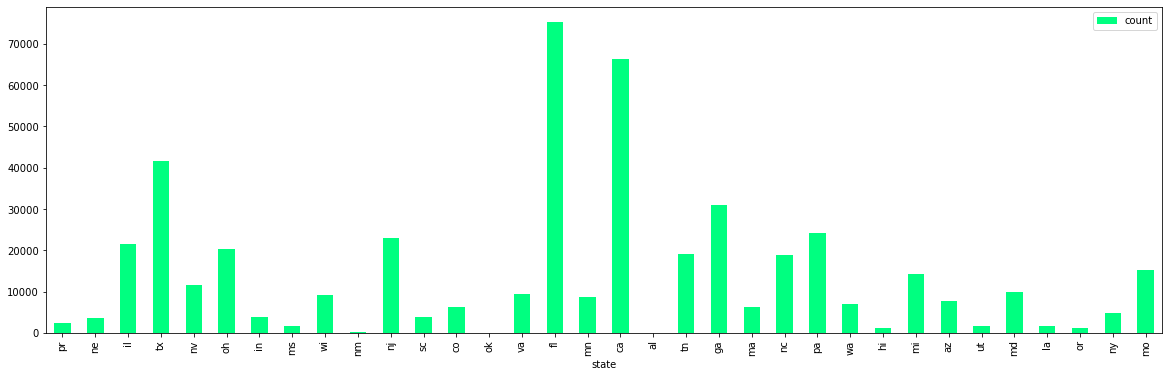

In [96]:
plot_basic_visuals(df, 'state')

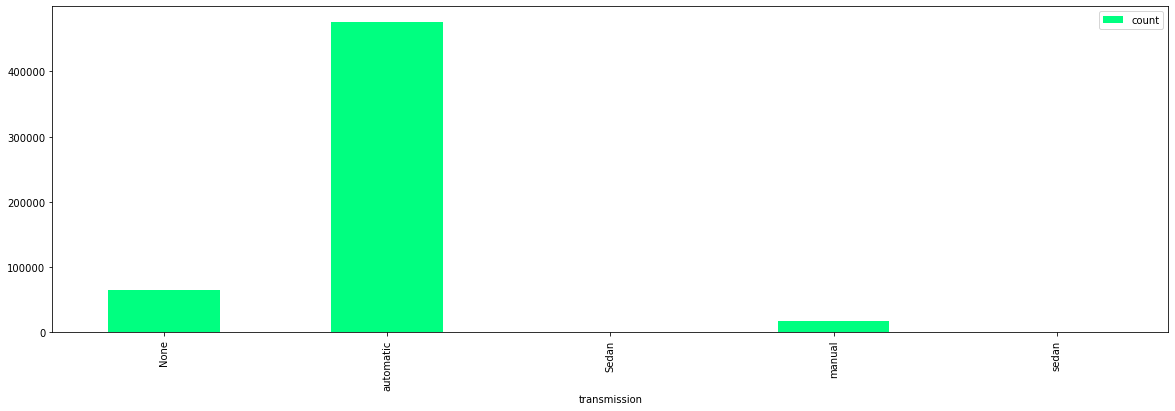

In [25]:
plot_basic_visuals(df, 'transmission')

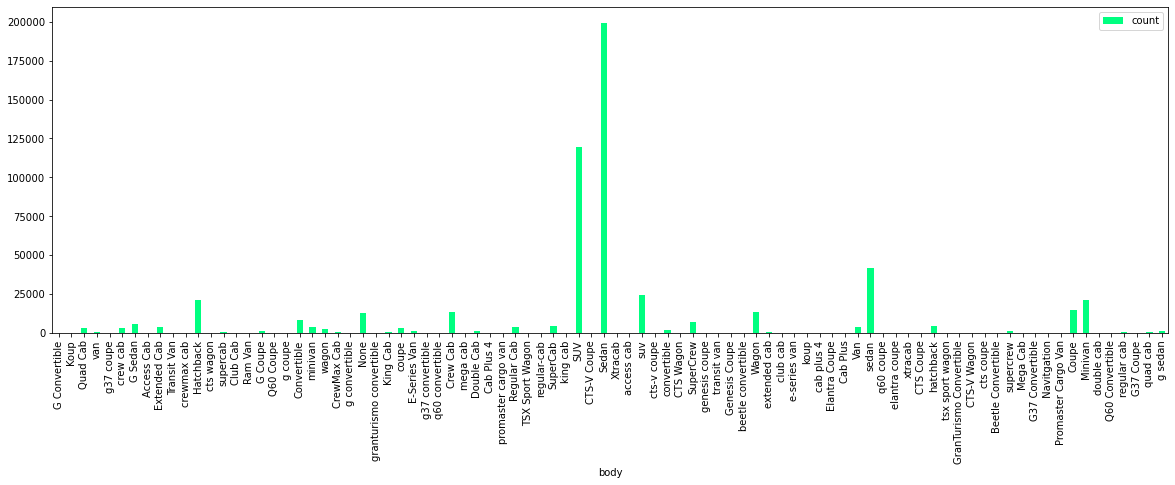

In [26]:
plot_basic_visuals(df, 'body')

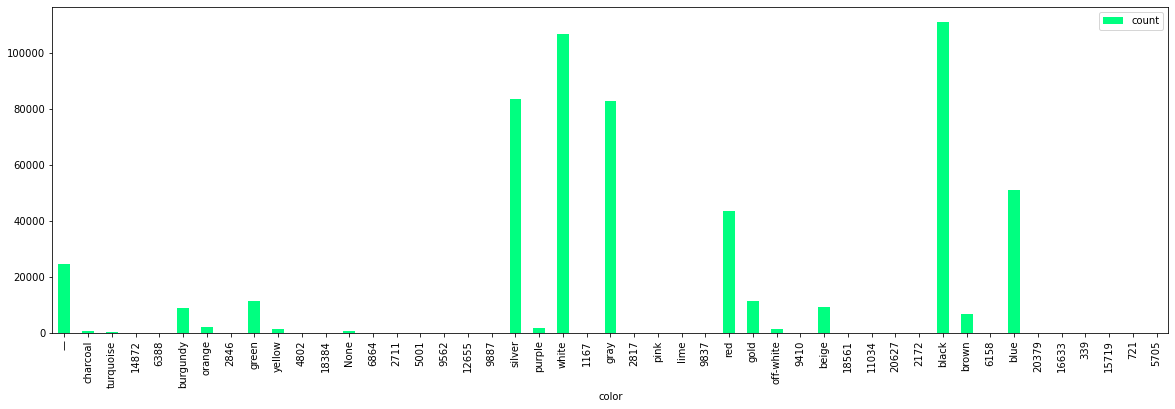

In [27]:
plot_basic_visuals(df, 'color')

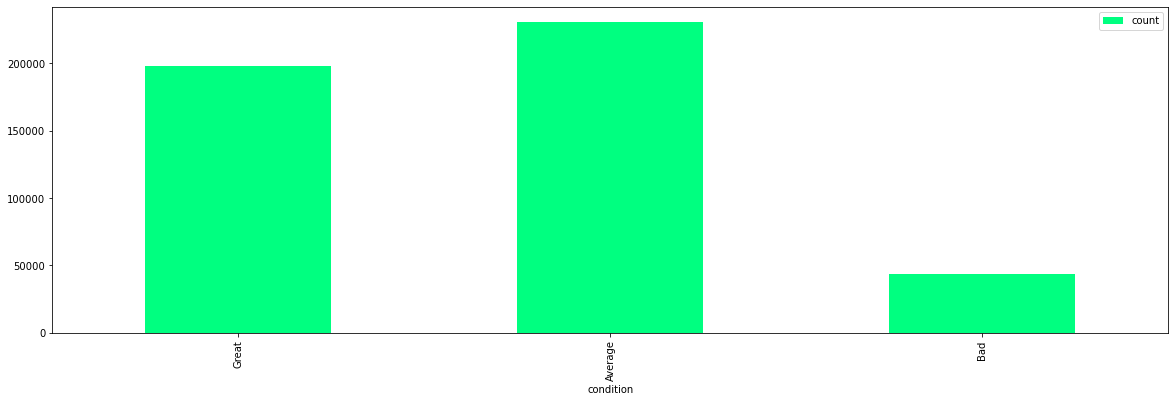

In [97]:
plot_basic_visuals(df, 'condition')

## Correlation of features against SellingPrice

In [7]:
def correlation_df_ind_dep_vars(df, column_name):
    '''
    This function takes in 2 parameters:
    Dataframe: Takes in the DF you are working with
    Column Name: Choose which column you want to find the correlation too
    
    Will return a dictionary with values and its correlation to the column name
    
    '''
    
    correlation_dict = {}
    
    for i in df.columns:
        if not(isinstance(df.select(i).take(1)[0][0], six.string_types)):
            val = df.stat.corr(f'{column_name}',i)
            correlation_dict[f'{i}'] = (val)
    return correlation_dict
            
cor_dict = correlation_df_ind_dep_vars(df, 'sellingprice')
print(f'Correlation to selling price:\n{cor_dict}')

Correlation to selling price:
{'year': 0.5789181720497839, 'odometer': -0.5773849819198499, 'mmr': 0.983491912061106, 'sellingprice': 1.0, 'saledate_year': 0.029529080806823954}


<br>

As we can see, year and condition have a high correlation with selling price.

<!-- The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median value tends to go up when the number of rooms goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; the median value tends to go down when the percentage of the lower status of the population goes up. Finally, coefficients close to zero mean that there is no linear correlation. -->


<br>

Our goal now is to use year and condition as our features.

Convert our original dataframe to use 3 columns, transform those values using vector assembler, train/split, apply linear regression

In [10]:
def transform_df(df, column_names):
    ''' SIMPLE FUNCTION THAT RETURNS 
    A NEW DF BASED ON COLUMN NAMES'''
    return df.select(column_names)


names = ['year', 'condition', 'sellingprice']
df_version2 = transform_df(df, names)
df_version2.show()

+----+---------+------------+
|year|condition|sellingprice|
+----+---------+------------+
|2015|    Great|       21500|
|2015|    Great|       21500|
|2014|    Great|       30000|
|2015|    Great|       27750|
|2014|    Great|       67000|
|2015|      Bad|       10900|
|2014|  Average|       65000|
|2014|  Average|        9800|
|2014|    Great|       32250|
|2014|  Average|       17500|
|2014|    Great|       49750|
|2015|    Great|       17700|
|2015|  Average|       12000|
|2015|    Great|       21500|
|2015|  Average|       14100|
|2014|    Great|       40000|
|2014|      Bad|       17000|
|2014|  Average|       67200|
|2015|      Bad|        7200|
|2014|  Average|       30000|
+----+---------+------------+
only showing top 20 rows



In [11]:
def data_processing(df, categorical_columns):
    '''
    FUNCTION TAKES IN 2 PARAMETERS:
    1. Data Frame --> data frame that you are working with that you want to process
    2. Column Names --> these are the categorical columns that will be used for processing/transformed
    
    Methods applied:
    1. Indexing --> Get index of string columns
    2. One hot encoding --> categorical values to numerical values
    3. Assembler --> vectorizing encoded values
    4. Pipeline --> create a pipeline do bring all these processes together
    
    Returns a transformed model as a dataframe
    '''
    
    # 1. INDEXER
    
    cc = categorical_columns
    indexers = [StringIndexer(inputCol = column, outputCol = f'{column}_indexed') for column in cc]
    
    # 2. One Hot Encoding
    
    encoders = [OneHotEncoder(dropLast = False, inputCol = idx.getOutputCol(), outputCol = f'{idx.getOutputCol()}_encoded') for idx in indexers]
    
    # 3. Assembler --> Vectorize encoded values
    
    assembler = VectorAssembler(inputCols = [encoded_val.getOutputCol() for encoded_val in encoders], outputCol = 'features')
    
    # 4. Pipeline
    
    pipeline = Pipeline(stages = indexers + encoders + [assembler])
    
    
    # Return our transformed moder
    model = pipeline.fit(df)
    
    transformed_df = model.transform(df)
    
    return transformed_df


trans_df = data_processing(df_version2, names)
trans_df.show()

+----+---------+------------+------------+-----------------+--------------------+--------------------+-------------------------+----------------------------+--------------------+
|year|condition|sellingprice|year_indexed|condition_indexed|sellingprice_indexed|year_indexed_encoded|condition_indexed_encoded|sellingprice_indexed_encoded|            features|
+----+---------+------------+------------+-----------------+--------------------+--------------------+-------------------------+----------------------------+--------------------+
|2015|    Great|       21500|        12.0|              1.0|               162.0|     (26,[12],[1.0])|            (3,[1],[1.0])|          (1806,[162],[1.0])|(1835,[12,27,191]...|
|2015|    Great|       21500|        12.0|              1.0|               162.0|     (26,[12],[1.0])|            (3,[1],[1.0])|          (1806,[162],[1.0])|(1835,[12,27,191]...|
|2014|    Great|       30000|         2.0|              1.0|               229.0|      (26,[2],[1.0])|   

In [15]:
df.show(10)

+----+---------+-------------------+-----------+------------+-----+---------+--------+-----+-----+------------+-----------+-------------+--------------+
|year|     make|              model|       body|transmission|state|condition|odometer|color|  mmr|sellingprice|   saledate|saledate_year|saledate_month|
+----+---------+-------------------+-----------+------------+-----+---------+--------+-----+-----+------------+-----------+-------------+--------------+
|2015|      Kia|            Sorento|        SUV|   automatic|   ca|    Great| 16639.0|white|20500|       21500|Dec 16 2014|         2014|           Dec|
|2015|      Kia|            Sorento|        SUV|   automatic|   ca|    Great|  9393.0|white|20800|       21500|Dec 16 2014|         2014|           Dec|
|2014|      BMW|           3 Series|      Sedan|   automatic|   ca|    Great|  1331.0| gray|31900|       30000|Jan 15 2015|         2015|           Jan|
|2015|    Volvo|                S60|      Sedan|   automatic|   ca|    Great| 1428

In [7]:
print('Originial Dataset')
old_df.printSchema()


print()
print('New Dataset')
df.printSchema()

Originial Dataset
root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- vin: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: double (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- mmr: integer (nullable = true)
 |-- sellingprice: integer (nullable = true)
 |-- saledate: string (nullable = true)


New Dataset
root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- body: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- odometer: double (nullable = true)
 |-- color: string (nullable = true